# Visual Computing in the Life Sciences

Assignment sheet 3

#### Group member: Dingming Liu, Faiza Khurshid, Danqi Wang

## Exercise 1 (GMMs and EM Algorithm for Image Segmentation, 18 Points)

### a) Read the grayscale image brain-noisy.png, which is provided along with this sheet on eCampus. Reduce the salt and pepper noise in the image using a median ﬁlter. Produce a binary mask that marks all pixels with an intensity greater than zero. In all further steps, only treat pixels within that mask. (3P)

In [96]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi

#path_original = '/Users/wangdanqi/Desktop/brain-noisy.png'
path_original='./brain-noisy.png'
image = cv2.imread(path_original,0)

In [97]:
def denoise(image):
    median = cv2.medianBlur(image, 5)
    return median


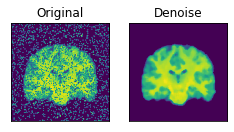

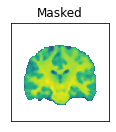

In [98]:
#path_mask = '/Users/wangdanqi/Desktop/mask.png'
path_mask='./mask.png'
mask = cv2.imread(path_mask,0)

# use np.nan to block the background pixels
img_masked = np.where(mask,denoise(image),np.nan)

def plot(image):
    plt.subplot(131),plt.imshow(image),plt.title('Original')
    plt.xticks([]), plt.yticks([])
    plt.subplot(132),plt.imshow(denoise(image)),plt.title('Denoise')
    plt.xticks([]), plt.yticks([])
    plt.show()
    plt.subplot(133),plt.imshow(img_masked),plt.title('Masked')
    plt.xticks([]), plt.yticks([])
    
plot(image)


### b) Plot a log-scaled histogram of the pixels within the mask. It should show how frequently diﬀerent intensity values occur in the image. What do the peaks in this histogram represent? Hint: One way to ﬁnd out is to create masks that highlight the pixels belonging to each peak. (3P)

In [99]:
#np.set_printoptions(threshold=np.inf)

rows, columns = image.shape
data = img_masked.reshape(rows*columns, 1)
data = np.float32(data)
# create new list to store masked pixel which filter np.nan
new_data = []    
bool_img = np.isnan(data)
for i in range(bool_img.shape[0]):
    if False in bool_img[i]:# False means the pixel has intensity and should add it to new_data list.
        new_data.append(data[i])
mask_data = np.mat(new_data)


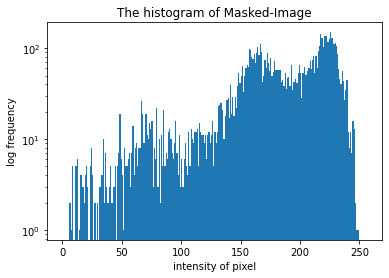

In [100]:
# histogram of masked image
mask_data = np.float32(mask_data)
plt.yscale('log')
plt.hist(mask_data,256,[0,256])
plt.title('The histogram of Masked-Image')
plt.xlabel('intensity of pixel')
plt.ylabel('log frequency')
plt.show()

### the first peak refers to CSF, the second peak refers to gray matter, and the last peak refers to white matter.
### proof as below:

<ipython-input-103-03275b06a7bf>:1: RuntimeWarning: invalid value encountered in greater
  index_1 = np.where((img_masked >0) & (img_masked <140)) #peak1
<ipython-input-103-03275b06a7bf>:1: RuntimeWarning: invalid value encountered in less
  index_1 = np.where((img_masked >0) & (img_masked <140)) #peak1
<ipython-input-103-03275b06a7bf>:2: RuntimeWarning: invalid value encountered in less
  index_2 = np.where((img_masked <200) & (img_masked >140)) #peak2
<ipython-input-103-03275b06a7bf>:2: RuntimeWarning: invalid value encountered in greater
  index_2 = np.where((img_masked <200) & (img_masked >140)) #peak2
<ipython-input-103-03275b06a7bf>:3: RuntimeWarning: invalid value encountered in less
  index_3 = np.where((img_masked <250) & (img_masked >200)) #peak3
<ipython-input-103-03275b06a7bf>:3: RuntimeWarning: invalid value encountered in greater
  index_3 = np.where((img_masked <250) & (img_masked >200)) #peak3


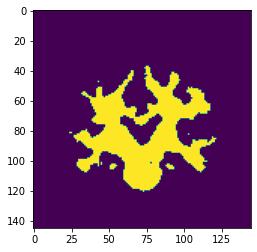

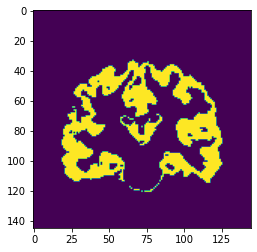

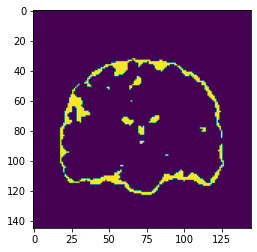

In [103]:
index_1 = np.where((img_masked >0) & (img_masked <140)) #peak1
index_2 = np.where((img_masked <200) & (img_masked >140)) #peak2
index_3 = np.where((img_masked <250) & (img_masked >200)) #peak3

def highlight_peak(index):
    
    mask = np.zeros(image.shape)
    x_data = index[1]
    y_data = index[0]
    zip_ = zip(x_data, y_data)
    for ele in zip_:
        pts = np.vstack(ele).astype(np.int32).T # generate mask 
        cv2.fillPoly(mask, [pts], (255))

    plt.imshow(mask)
    plt.show()


highlight_peak(index_3)
highlight_peak(index_2)
highlight_peak(index_1)


### c) Now, we will use a three-compartment Gaussian Mixture Model for image segmentation: Based on their gray level, pixels that fall within the mask from b) should be assigned to one of three Gaussians, capturing corticospinal ﬂuid (dark), gray matter (medium), or white matter (bright). To start this process, initialize the parameters of a three-compartment GMM to reasonable values and use them to compute the responsibilities ρ ik of cluster k for pixel i. (3P)

In [104]:
# use k means algorithm to intialize the parameters(mu, var, pi)

In [105]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 0.5)
num_clusters = 3
compact,label,center=cv2.kmeans(mask_data, num_clusters, None, criteria, num_clusters, cv2.KMEANS_RANDOM_CENTERS)

#label_img = label.reshape((rows, columns))
#label_img = cv2.convertScaleAbs(label_img)
mu = []
var = []
Pi = []
cluster1 = mask_data[label == 0]
cluster2 = mask_data[label == 1]
cluster3 = mask_data[label == 2]
cluster = [cluster1, cluster2, cluster3]
for c in cluster:
    mu.append(np.mean(c))
    var.append(np.var(c))
    Pi.append(c.shape[1]/len(new_data))
print(mu, var, Pi)


[74.295166, 217.6918, 162.90742] [790.2818, 153.47964, 254.05528] [0.09993642720915448, 0.48391608391608393, 0.4161474888747616]


In [106]:
# E step: compute responsibilities

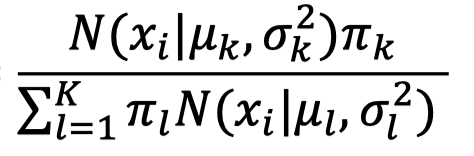

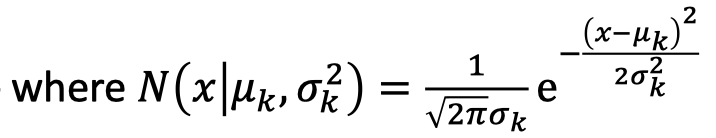

In [107]:
def Normal(x,mu,variance):
    ''' the formula of Gaussian distribution'''
    return np.exp(-(x-mu)**2/(2*variance))/(np.sqrt(2*np.pi*variance))

def Gaussian(data, Mu, Var, Pi_):
    
    gauss = Normal(data, Mu, Var)
    Gamma = Pi_ * gauss
    return Gamma

# create matrix to store propability of each point
r = np.zeros((len(new_data),3)) 

def update_r(mu, var, Pi):
    for k in range(len(new_data)):
        M = Gaussian(new_data[k], mu[0], var[0], Pi[0]) + Gaussian(new_data[k], mu[1], var[1], Pi[1]) + Gaussian(new_data[k], mu[2], var[2], Pi[2])
        r[k, 0] = Gaussian(new_data[k], mu[0], var[0], Pi[0])/M
        r[k, 1] = Gaussian(new_data[k], mu[1], var[1], Pi[1])/M
        r[k, 2] = Gaussian(new_data[k], mu[2], var[2], Pi[2])/M
    return r
print('The responsibility matrix is:\n', update_r(mu,var,Pi))





The responsibility matrix is:
 [[1.00000000e+00 3.88710562e-36 2.29733788e-09]
 [9.99997437e-01 4.33339630e-28 2.57691272e-06]
 [1.00000000e+00 2.16339982e-38 3.08341602e-10]
 ...
 [9.99999642e-01 1.52943899e-30 3.11327625e-07]
 [9.99999940e-01 1.19742423e-32 4.97071539e-08]
 [1.00000000e+00 4.46839492e-33 3.41648452e-08]]


### d) Visualize the responsibilities by mapping the probabilities of belonging to the CSF, gray matter, and white matter clusters to the red, blue, and green color channels, respectively. Please submit the resulting image. (2P)

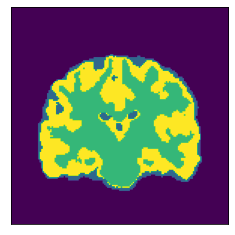

In [109]:
def create_list(r):
    N= len(new_data)# the intensity data in list.
    order = np.zeros(N)# label list
    k = 3

    for i in range(N):
        for j in range(k):
            if r[i,j] == max(r[i,:]):# get the cluster information.
                order[i] = j
            
# create list to store the pixels belong to each cluster
    pixel_list1 = []
    pixel_list2 = []
    pixel_list3 = []
    for m in range(len(order)):
        if order[m] == 0:
            pixel_list1.append(new_data[m])# the first cluster list
        elif order[m] == 1:
            pixel_list2.append(new_data[m])# the second cluster list
        elif order[m] == 2:
            pixel_list3.append(new_data[m])# the third cluster list
    return pixel_list1, pixel_list2, pixel_list3
             
image_ = np.zeros(image.shape,dtype=float)  
    
def label_image(list_):
    index_list1 = []
    for elem in list_:  
        index = np.where(img_masked == elem)
        x_data = index[0]
        y_data = index[1]
        zip_ = zip(x_data, y_data)
        index_list1.extend(zip_)
    return set(index_list1)
    
for x, y in label_image(create_list(r)[0]):
    image_[x,y] = 1
    
for x, y in label_image(create_list(r)[1]):
    image_[x, y] = 2
    
for x, y in label_image(create_list(r)[2]):
    image_[x, y] = 3

plt.imshow(image_)
plt.xticks([])
plt.yticks([])
plt.savefig('Ex1-d.png')
plt.show()
            

### e) Use the update rules provided in the lecture to re-compute the parameters µ k , σ k , and π k . (3P)

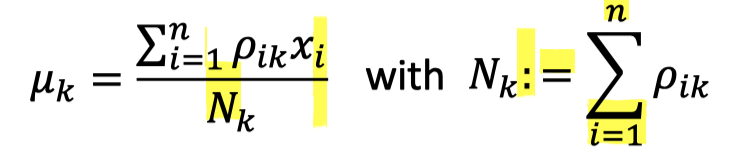

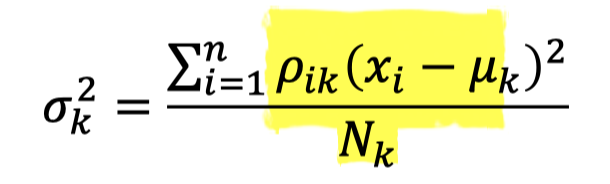

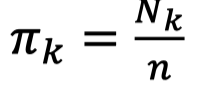

In [110]:
# M step: fitting GMM to data

def update_Nk(r):
    N_k = []
    for i in range(0,3):
        N_ = sum(r[:,i])
        N_k.append(N_)
    return N_k


def update_mu(r):
    mu_update = []
    for i in range(0,3):
        update = sum(r[m,i]*float(new_data[m]) for m in range(r.shape[0]))/update_Nk(r)[i]
        mu_update.append(update)
    return mu_update

mu__ = update_mu(r)

def update_var(r):
    var_update = []
    for i in range(0,3):
        update = sum(r[m,i]*(float(new_data[m])-mu__[i])**2 for m in range(r.shape[0]))/update_Nk(r)[i]
        var_update.append(update)
    return var_update

def update_Pi(r):
    pi_update = []
    for i in range(0, 3):
        update = update_Nk(r)[i]/r.shape[0]
        pi_update.append(update)
    return pi_update

print(f'Nk: {update_Nk(r)}\nmu: {update_mu(r)}\nvar: {update_var(r)}\nPi: {update_Pi(r)}')

Nk: [828.310395895237, 3711.3577085415045, 3325.3318991881188]
mu: [77.35216206018494, 218.06325335363147, 164.41807349283042]
var: [923.9368035218697, 154.03693543547155, 280.73205455317395]
Pi: [0.10531600710683242, 0.47188273471602094, 0.42280125863803164]


### f) Iterate the E and M steps of the algorithm until convergence. Please submit the ﬁnal parameter values, a visualization of the ﬁnal responsibilities, and your code. (2P)

In [112]:
import copy

def iteration_function():
    a = update_mu(r)
    b = update_var(r)
    c = update_Pi(r)
    for i in range(100):# set iteration of 100.
        err_mu = 0     
        err_var = 0 
        err_pi = 0
        Old_mu = copy.deepcopy(a)
        Old_var = copy.deepcopy(b)
        Old_Pi = copy.deepcopy(c)
    
        new_r = update_r(a, b, c)
        a = update_mu(new_r)
        b = update_var(new_r)
        c = update_Pi(new_r)
        
        err_mu += (abs(Old_mu[0]-a[0])+abs(Old_mu[1]-a[1])+abs(Old_mu[2]-a[2]))
        err_var += (abs(Old_var[0]-b[0])+abs(Old_var[1]-b[1])+abs(Old_var[2]-b[2]))
        err_pi += (abs(Old_Pi[0]-c[0])+abs(Old_Pi[1]-c[1])+abs(Old_Pi[2]-c[2]))
    
        # set the threshold to make sure parameter stabilized. 
        if err_mu <=1e-10 and err_var<=1e-10 and err_pi <= 1e-10: 
            return a, b, c, new_r

final_mu = iteration_function()[0]
final_var = iteration_function()[1]
final_Pi = iteration_function()[2]
final_r = iteration_function()[3]
print(f'The final parameter of mu: {final_mu}\nThe final parameter of variance: {final_var}\nThe final parameter of Pi: {final_Pi}')

The final parameter of mu: [74.44964371626496, 221.4746705792945, 170.26086819446164]
The final parameter of variance: [911.9684921712022, 107.69749184811408, 561.0686817540377]
The final parameter of Pi: [0.09684517027837022, 0.38233559840105036, 0.5208192333333189]


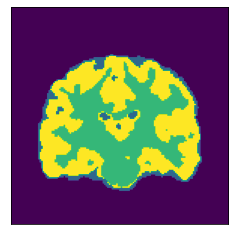

In [113]:
image__ = np.zeros(image.shape,dtype=int)  
for x, y in label_image(create_list(final_r)[0]):
    image__[x,y] = 1
    
for x, y in label_image(create_list(final_r)[1]):
    image__[x, y] = 2
    
for x, y in label_image(create_list(final_r)[2]):
    image__[x, y] = 3


plt.imshow(image__)
plt.xticks([])
plt.yticks([])
plt.savefig('Ex1-f.png')
plt.show()

### g) Create and submit a plot that illustrates the convergence of your algorithm. (2P)

In [114]:
# calculate the probability of each pixel according to the following formula.

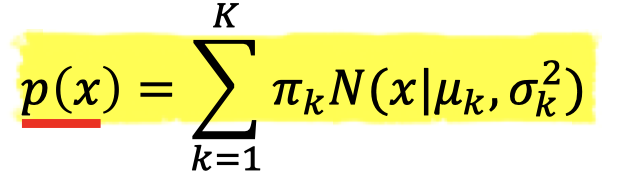

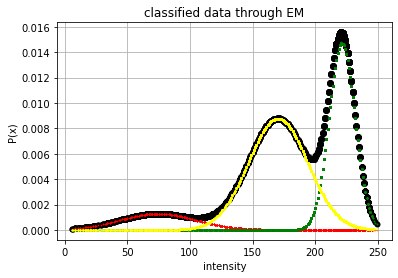

In [116]:
import scipy.stats as stats

N= len(new_data)# the intensity data in list.
order = np.zeros(N)
probability = np.zeros(N)
k = 3

for i in range(N):
    for j in range(k):
        if final_r[i,j] == max(final_r[i,:]):
            order[i] = j
        probability[i] += Gaussian(new_data[i], final_mu[j], final_var[j], final_Pi[j])# the probability of each pixel 

final_mu = iteration_function()[0]
final_var = iteration_function()[1]
final_Pi = iteration_function()[2]


plt.title('classified data through EM')
plt.ylabel('P(x)')
plt.xlabel('intensity')
#plot the probability density.
plt.plot(new_data,probability,'.', markersize = 10, c = 'black')

# Three Gaussian mixture plots
# curve in red: gray matter; green: white matter; yellow: CSF.
plt.plot(new_data,final_Pi[0]*stats.norm.pdf(new_data,final_mu[0],np.sqrt(final_var[0])).ravel(), 
         '.', markersize = 1, c='red')
plt.plot(new_data,final_Pi[1]*stats.norm.pdf(new_data,final_mu[1],np.sqrt(final_var[1])).ravel(), 
         '.', markersize = 2, c='green')
plt.plot(new_data,final_Pi[2]*stats.norm.pdf(new_data,final_mu[2],np.sqrt(final_var[2])).ravel(), 
         '.', markersize = 2, c='yellow')

plt.rcParams['agg.path.chunksize'] = 10000

plt.grid()
plt.savefig('Ex1-g.png')
plt.show()


from https://stackoverflow.com/questions/55187037/how-can-i-do-a-histogram-with-1d-gaussian-mixture-with-sklearn

#### According to the plot, the Gaussian mixture are overlapped with our probability density plot, so the algorithm works well and comes to convergence. 

## Exercise 2 (Markov Random Fields, 20 Points)

### a) Load the noisy brain image brain-noisy.png again and download the mask.png which is provided along with this sheet on eCampus. Based on your implementation of the EM algorithm from Exercise 1, but leaving out the median filtering, create a discrete (hard / non-probabilistic) label image that contains the most likely material for each pixel. Output it as an RGB image. For the segmentation use the mask.png in order to apply the algorithms only on the foreground pixels.(3P)

In [117]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi


path_original='./brain-noisy.png'
image = cv2.imread(path_original,0)

In [118]:
# E step
def Normal(x,mu,variance):
    ''' the formula of Gaussian distribution'''
    return np.exp(-(x-mu)**2/(2*variance))/(np.sqrt(2*np.pi*variance))

def Gaussian(data, Mu, Var, Pi_):
    
    gauss = Normal(data, Mu, Var)
    Gamma = Pi_ * gauss
    return Gamma

# create matrix to store propability of each point
r = np.zeros((len(new_data),3)) 

def update_r(mu, var, Pi):
    for k in range(len(new_data)):
        M = Gaussian(new_data[k], mu[0], var[0], Pi[0]) + Gaussian(new_data[k], mu[1], var[1], Pi[1]) + Gaussian(new_data[k], mu[2], var[2], Pi[2])
        r[k, 0] = Gaussian(new_data[k], mu[0], var[0], Pi[0])/M
        r[k, 1] = Gaussian(new_data[k], mu[1], var[1], Pi[1])/M
        r[k, 2] = Gaussian(new_data[k], mu[2], var[2], Pi[2])/M
    return r
print('The responsibility matrix is:\n', update_r(mu,var,Pi))


The responsibility matrix is:
 [[1.00000000e+00 3.88710562e-36 2.29733788e-09]
 [9.99997437e-01 4.33339630e-28 2.57691272e-06]
 [1.00000000e+00 2.16339982e-38 3.08341602e-10]
 ...
 [9.99999642e-01 1.52943899e-30 3.11327625e-07]
 [9.99999940e-01 1.19742423e-32 4.97071539e-08]
 [1.00000000e+00 4.46839492e-33 3.41648452e-08]]


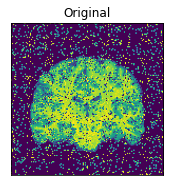

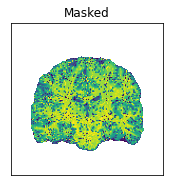

In [119]:
path_mask='./mask.png'
mask = cv2.imread(path_mask,0)

# use np.nan to block the background pixels
img_masked = np.where(mask,image,np.nan)

def plot(image):
    plt.subplot(121),plt.imshow(image),plt.title('Original')
    plt.xticks([]), plt.yticks([])    
    plt.show()
    plt.subplot(122),plt.imshow(img_masked),plt.title('Masked')
    plt.xticks([]), plt.yticks([])
    
plot(image)

In [120]:
# M step: fitting GMM to data

def update_Nk(r):
    N_k = []
    for i in range(0,3):
        N_ = sum(r[:,i])
        N_k.append(N_)
    return N_k


def update_mu(r):
    mu_update = []
    for i in range(0,3):
        update = sum(r[m,i]*float(new_data[m]) for m in range(r.shape[0]))/update_Nk(r)[i]
        mu_update.append(update)
    return mu_update

mu__ = update_mu(r)

def update_var(r):
    var_update = []
    for i in range(0,3):
        update = sum(r[m,i]*(float(new_data[m])-mu__[i])**2 for m in range(r.shape[0]))/update_Nk(r)[i]
        var_update.append(update)
    return var_update

def update_Pi(r):
    pi_update = []
    for i in range(0, 3):
        update = update_Nk(r)[i]/r.shape[0]
        pi_update.append(update)
    return pi_update

print(f'Nk: {update_Nk(r)}\nmu: {update_mu(r)}\nvar: {update_var(r)}\nPi: {update_Pi(r)}')

Nk: [828.310395895237, 3711.3577085415045, 3325.3318991881188]
mu: [77.35216206018494, 218.06325335363147, 164.41807349283042]
var: [923.9368035218697, 154.03693543547155, 280.73205455317395]
Pi: [0.10531600710683242, 0.47188273471602094, 0.42280125863803164]


In [122]:
import copy

def iteration_function():
    a = update_mu(r)
    b = update_var(r)
    c = update_Pi(r)
    for i in range(100):# set iteration of 100.
        err_mu = 0     
        err_var = 0 
        err_pi = 0
        Old_mu = copy.deepcopy(a)
        Old_var = copy.deepcopy(b)
        Old_Pi = copy.deepcopy(c)
    
        new_r = update_r(a, b, c)
        a = update_mu(new_r)
        b = update_var(new_r)
        c = update_Pi(new_r)
        
        err_mu += (abs(Old_mu[0]-a[0])+abs(Old_mu[1]-a[1])+abs(Old_mu[2]-a[2]))
        err_var += (abs(Old_var[0]-b[0])+abs(Old_var[1]-b[1])+abs(Old_var[2]-b[2]))
        err_pi += (abs(Old_Pi[0]-c[0])+abs(Old_Pi[1]-c[1])+abs(Old_Pi[2]-c[2]))
    
        # set the threshold to make sure parameter stabilized. 
        if err_mu <=1e-10 and err_var<=1e-10 and err_pi <= 1e-10: 
            return a, b, c, new_r

final_mu = iteration_function()[0]
final_var = iteration_function()[1]
final_Pi = iteration_function()[2]
final_r = iteration_function()[3]
print(f'The final parameter of mu: {final_mu}\nThe final parameter of variance: {final_var}\nThe final parameter of Pi: {final_Pi}')

The final parameter of mu: [74.44964371626496, 221.4746705792945, 170.26086819446164]
The final parameter of variance: [911.9684921712022, 107.69749184811408, 561.0686817540377]
The final parameter of Pi: [0.09684517027837022, 0.38233559840105036, 0.5208192333333189]


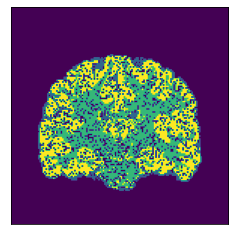

In [123]:
image__ = np.zeros(image.shape,dtype=int)  
for x, y in label_image(create_list(final_r)[0]):
    image__[x,y] = 1
    
for x, y in label_image(create_list(final_r)[1]):
    image__[x, y] = 2
    
for x, y in label_image(create_list(final_r)[2]):
    image__[x, y] = 3


plt.imshow(image__)
plt.xticks([])
plt.yticks([])
plt.savefig('Ex2-a.png')
plt.show()


RGB
(432, 288)
(288, 432, 3)


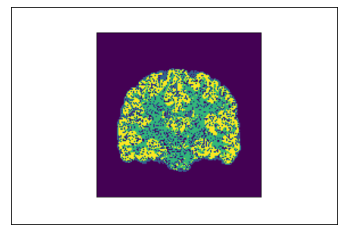

In [124]:
from PIL import Image

#convert to RGB image
Img=Image.open('./2-a.png')
out=Img.convert("RGB")
img=np.array(out)
print(out.mode)
print(out.size)
print(img.shape)

plt.imshow(out)
plt.xticks([])
plt.yticks([])
plt.savefig('Ex2-a-RGB')
plt.show()

### b) Implement one iteration of the Iterated Conditional Modes (ICM) algorithm for a Markov Random Field that uses the Potts model and β= 0:5. Use your EM parameters to initialize the unary potentials and use the labels of the neighbouring pixels to compute the pairwise potentials. Finally, for each pixel pick the label that minimizes the energy. Output the result as an RGB image. (5P)

So sorry for not able to complete the part below, I don't clearly understand the MRF I think.

In [125]:
img = cv2.imread('2-a.png')
 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
img = gray
 
img_double = np.array(img, dtype = np.float64)
cluster_num = 3
 
max_iter =2
 
label=np.random.randint(1, cluster_num + 1, size = img_double.shape)
 
iter=0
 
f_u = np.array([0,1,0,0,0,0,0,0,0]).reshape(3, 3)
f_d = np.array([0,0,0,0,0,0,0,1,0]).reshape(3, 3)
f_l = np.array([0,0,0,1,0,0,0,0,0]).reshape(3, 3)
f_r = np.array([0,0,0,0,0,1,0,0,0]).reshape(3, 3)
f_ul = np.array([1,0,0,0,0,0,0,0,0]).reshape(3, 3)
f_ur = np.array([0,0,1,0,0,0,0,0,0]).reshape(3, 3)
f_dl = np.array([0,0,0,0,0,0,1,0,0]).reshape(3, 3)
f_dr = np.array([0,0,0,0,0,0,0,0,1]).reshape(3, 3)
 

while iter < max_iter:
    iter = iter + 1
    #print(iter)
 
 
    label_u = cv2.filter2D(np.array(label, dtype = np.uint8), -1 , f_u)
    label_d = cv2.filter2D(np.array(label, dtype = np.uint8), -1 , f_d)
    label_l = cv2.filter2D(np.array(label, dtype = np.uint8), -1 , f_l)
    label_r = cv2.filter2D(np.array(label, dtype = np.uint8), -1 , f_r)
    label_ul = cv2.filter2D(np.array(label, dtype = np.uint8), -1 , f_ul)
    label_ur = cv2.filter2D(np.array(label, dtype = np.uint8), -1 , f_ur)
    label_dl = cv2.filter2D(np.array(label, dtype = np.uint8), -1 , f_dl)
    label_dr = cv2.filter2D(np.array(label, dtype = np.uint8), -1 , f_dr)
    m, n = label.shape
    p_c = np.zeros((cluster_num, m , n))
    #print(m,n)
 
    for i in range(cluster_num):
        label_i = (i+1) * np.ones((m, n))
        u_T = 1 * np.logical_not(label_i - label_u)
        d_T = 1 * np.logical_not(label_i - label_d)
        l_T = 1 * np.logical_not(label_i - label_l)
        r_T = 1 * np.logical_not(label_i - label_r)
        ul_T = 1 * np.logical_not(label_i - label_ul)
        ur_T = 1 * np.logical_not(label_i - label_ur)
        dl_T = 1 * np.logical_not(label_i - label_dl)
        dr_T = 1 * np.logical_not(label_i - label_dr)
        temp = u_T + d_T + l_T + r_T + ul_T + ur_T + dl_T + dr_T
 
        p_c[i, :] = (1.0/8) * temp
 
    p_c[p_c == 0] = 0.001 
    mu = final_mu
    sigma = final_var
    
 
    p_sc = np.zeros((cluster_num, m , n))
    #print(p_sc)
    one_a = np.ones((m, n))
 
    for j in range(3):
        MU = mu[j]* one_a
        p_sc[j] = (1.0/np.sqrt(2 * np.pi * sigma[j])) * np.exp(-1. * (( img - MU)**2) /(2 * sigma[j]))
 
    X_out = np.log(p_c) + np.log(p_sc)
    label_c = X_out.reshape(3, m * n)
    label_c_t = label_c.T
    label_m = np.argmax(label_c_t, axis = 1)
    label_m = label_m + np.ones(label_m.shape)  
    label= label_m.reshape(m, n)

label = label - np.ones(label.shape) 
lable_w = 255 * label 
 
cv2.imwrite('Ex2-b.png', lable_w)

True

### c) Apply your ICM iteration five times overall. Output the number of pixels whose label changes in each iteration, and output the final labels as an RGB image. (3P)

In [126]:
max_iter =2
 
label=np.random.randint(1, cluster_num + 1, size = img_double.shape)
 
iter=5
 
f_u = np.array([0,1,0,0,0,0,0,0,0]).reshape(3, 3)
f_d = np.array([0,0,0,0,0,0,0,1,0]).reshape(3, 3)
f_l = np.array([0,0,0,1,0,0,0,0,0]).reshape(3, 3)
f_r = np.array([0,0,0,0,0,1,0,0,0]).reshape(3, 3)
f_ul = np.array([1,0,0,0,0,0,0,0,0]).reshape(3, 3)
f_ur = np.array([0,0,1,0,0,0,0,0,0]).reshape(3, 3)
f_dl = np.array([0,0,0,0,0,0,1,0,0]).reshape(3, 3)
f_dr = np.array([0,0,0,0,0,0,0,0,1]).reshape(3, 3)
 

while iter < max_iter:
    iter = iter + 1
    #print(iter)
 
 
    label_u = cv2.filter2D(np.array(label, dtype = np.uint8), -1 , f_u)
    label_d = cv2.filter2D(np.array(label, dtype = np.uint8), -1 , f_d)
    label_l = cv2.filter2D(np.array(label, dtype = np.uint8), -1 , f_l)
    label_r = cv2.filter2D(np.array(label, dtype = np.uint8), -1 , f_r)
    label_ul = cv2.filter2D(np.array(label, dtype = np.uint8), -1 , f_ul)
    label_ur = cv2.filter2D(np.array(label, dtype = np.uint8), -1 , f_ur)
    label_dl = cv2.filter2D(np.array(label, dtype = np.uint8), -1 , f_dl)
    label_dr = cv2.filter2D(np.array(label, dtype = np.uint8), -1 , f_dr)
    m, n = label.shape
    p_c = np.zeros((cluster_num, m , n))
    #print(m,n)
 
    for i in range(cluster_num):
        label_i = (i+1) * np.ones((m, n))
        u_T = 1 * np.logical_not(label_i - label_u)
        d_T = 1 * np.logical_not(label_i - label_d)
        l_T = 1 * np.logical_not(label_i - label_l)
        r_T = 1 * np.logical_not(label_i - label_r)
        ul_T = 1 * np.logical_not(label_i - label_ul)
        ur_T = 1 * np.logical_not(label_i - label_ur)
        dl_T = 1 * np.logical_not(label_i - label_dl)
        dr_T = 1 * np.logical_not(label_i - label_dr)
        temp = u_T + d_T + l_T + r_T + ul_T + ur_T + dl_T + dr_T
 
        p_c[i, :] = (1.0/8) * temp
 
    p_c[p_c == 0] = 0.001
 
    mu = final_mu
    sigma = final_var
    
 
    p_sc = np.zeros((cluster_num, m , n))
    #print(p_sc)
    one_a = np.ones((m, n))
 
    for j in range(3):
        MU = mu[j]* one_a
        p_sc[j] = (1.0/np.sqrt(2 * np.pi * sigma[j])) * np.exp(-1. * (( img - MU)**2) /(2 * sigma[j]))
 
    X_out = np.log(p_c) + np.log(p_sc)
    label_c = X_out.reshape(3, m * n)
    label_c_t = label_c.T
    label_m = np.argmax(label_c_t, axis = 1)
    label_m = label_m + np.ones(label_m.shape)  
    label= label_m.reshape(m, n)

label = label - np.ones(label.shape) 
lable_w = 255 * label 

cv2.imwrite('Ex2-c.png', lable_w)

True

### f) Compare the output from task e) to the result of segmentation using GMM. How do the segmentation images differ and how would you explain the difference? (2P)

The CSF region has more labels in the result using MRF.

## Exercise 3 (Nonstationary and Anisotropic Markov Random Fields, 12 Points)

### a) Why is it a more difficult problem to segment specific brain structures, compared to segmenting tissue types? (2P

There can be difficult in labeling brain structures based on MRI image intensities. there might be no global classification scheme that can diffrentiate structures from each others but by using additional MRI sequences with differeing image modelities can help to seprate class distribution. But still we requaired spatial information to disambiguate the classification problem.

### b) One strategy that can be used to address the above-mentioned challenge is to make MRFs nonstationary. Briefly explain what "nonstationary" means here and how it helps to reduce ambiguities in the segmentation. What are the roles of image registration and a brain atlas in this context? (6P)

the use of spatial information to help in classification is facilitated by the construction of probabalistic atlas. both global and local spatial information use for the accurate labeling of a large number of structures. Local information is incorporated into the classification procedure by modeling the segmentation as nonstationary Markov random field.

the isotropic Markov fields working in order to yield smoother segmentation, the introduction of nonstationary anisotropy into the segmentation model allows the spatial relationships of anatomical classes to one another to be incorporated into the segmentation procedure in a principled fashion. The incorporation of high dimensional registration techniques should further improve accuracy of labelling. Main role of regestration is to bring structure into alignment across subjects.it seems reasonable to seek transformation that maximize the probablity of segmentation ,given the observed image. registration procedures have been developed in order to align images with the assumption that if locations with similar intensities are aligned everywhere in the brain, then anatomical correspondence will follow.

### c) Another strategy is to make MRFs anisotropic. Explain what \anisotropy" means in this context and how it helps to capture prior knowledge that can guide the segmentation. (4P)

the prior probability of a given spatial arrangement of anatomical labels is incorporated into the final segmentation procedure. These priors are also computed from the training set for each point in the atlas by modeling the segmentation as an anisotropic nonstationary Markov random field, resulting in procedure that even using a low-dimensional linear transform is compareable in term of accuracy to manual labeling.